In [1]:
%load_ext autoreload
%autoreload 2
from storytelling import *
from bert_extractive_summarizer.summarizer import Summarizer
from bert_extractive_summarizer.summarizer.coreference_handler import CoreferenceHandler
tool = language_check.LanguageTool('en-US')

/data/jw3514/anaconda3/envs/storytell/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/data/jw3514/anaconda3/envs/storytell/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/data/jw3514/anaconda3/envs/storytell/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/data/jw3514/anaconda3/envs/storytell

#### Load  glove twitter Word embeddings

In [2]:
word_embeddings = LoadWordEmbeddings(fil="../dat/glove/glove.twitter.27B.100d.txt")

##### Load tweets and preprocess

In [3]:
#datfile = "../dat/wildfire_yosemite.csv"
#datfile = "../dat/4499.csv.gz"
datfile = "../dat/4296.csv.gz"
#datfile = "../dat/4884.csv.gz"
df = pd.read_csv(datfile, index_col="id")
df = df[df["rt_id"].isna()] # Drop retweets
print(df.shape)
df.head(5)

(41466, 11)


,text,created_at,retweet_count,user_id,user_followers_count,rt_id,rt_text,rt_created_at,rt_retweet_count,rt_user_id,rt_user_followers_count
id,,,,,,,,,,,
468196116060987393,Frickin billboard music awards since when,Mon May 19 01:07:07 +0000 2014,0,766509907,1704,NaN,NaN,NaN,NaN,NaN,NaN
468196134788157443,Ariana Grande Joins Iggy Azalea On Stage for '...,Mon May 19 01:07:11 +0000 2014,0,2228148963,30,NaN,NaN,NaN,NaN,NaN,NaN
468196125598826496,Billboard Music Awards @ MGM Grand Garden Aren...,Mon May 19 01:07:09 +0000 2014,0,1892187614,390,NaN,NaN,NaN,NaN,NaN,NaN
468196135157248000,Didn't even remember the billboard music award...,Mon May 19 01:07:11 +0000 2014,0,1577950704,361,NaN,NaN,NaN,NaN,NaN,NaN
468196117122121728,Yay for the billboard music awards ☺️ http://t...,Mon May 19 01:07:07 +0000 2014,0,403102090,224,NaN,NaN,NaN,NaN,NaN,NaN


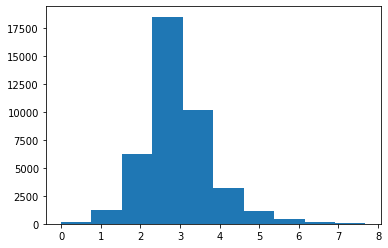

In [4]:
df = df[df["user_followers_count"]>0]
plt.hist(np.log10(df["user_followers_count"].values))
plt.show()

In [5]:
df1 = df[df["user_followers_count"]>10**4]
df1.shape

(4138, 11)

In [6]:
tids, row_sentences, clean_sentences = readsencence(df1)

In [7]:
sentence_vectors = Sentence2WE(clean_sentences, word_embeddings)
print(sentence_vectors.shape)

(1700, 100)


(1700, 40)


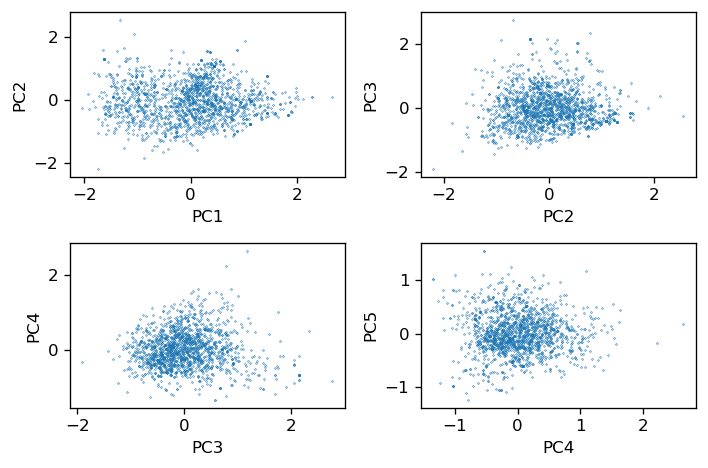

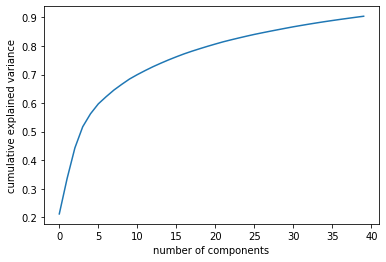

In [8]:
pca = PCA(n_components=40, svd_solver='arpack')
X = pca.fit_transform(sentence_vectors)
print(X.shape)
fig, axs = plt.subplots(2,2,dpi=120)
for i,(j,k) in enumerate([(0,0),(0,1),(1,0),(1,1)]):
    axs[j,k].scatter(X[:,i], X[:,i+1], s=0.1)
    axs[j,k].set_xlabel("PC%d"%(i+1))
    axs[j,k].set_ylabel("PC%d"%(i+2))
fig.tight_layout()
plt.show()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [9]:
NC = 40
for nc, vexp in enumerate(np.cumsum(pca.explained_variance_ratio_)):
    if vexp > 0.8:
        NC = nc+1
        break
print(NC)

21


In [10]:
tsne = TSNE(n_components=2)
Y = tsne.fit_transform(X[:, :NC])

In [11]:
#Agg = sklearn.cluster.AgglomerativeClustering(n_clusters=10, affinity="cosine",linkage="average")
Agg = sklearn.cluster.AgglomerativeClustering(distance_threshold=1.5, n_clusters=None, affinity="cosine",linkage="complete")
Agg = Agg.fit(X[:, :NC])
clusters = Agg.fit_predict(X[:, :NC])
groups = AssignCluster(Y, clusters)
print(len(groups))
#centers = kmeans.cluster_centers_ 

14


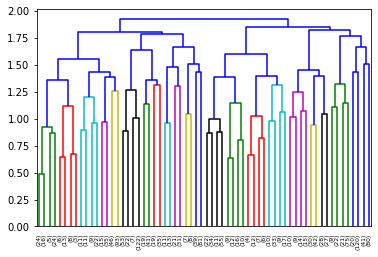

In [12]:
plot_dendrogram(Agg, truncate_mode='level', p=5)

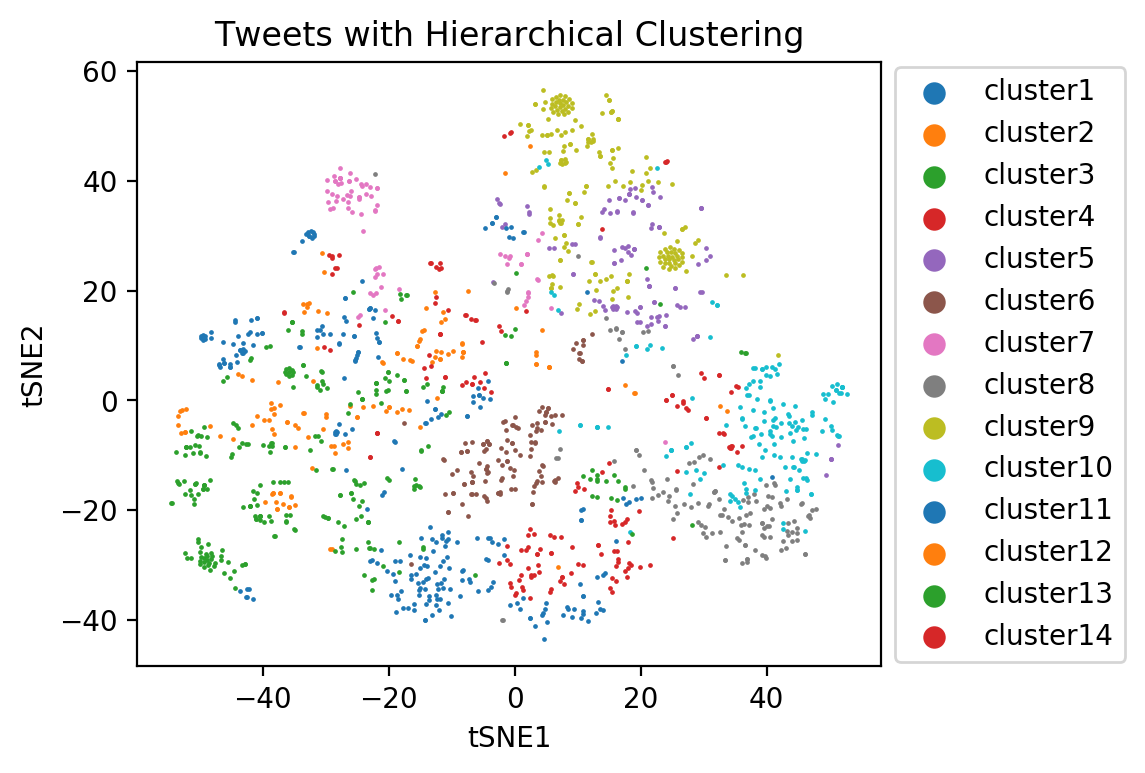

In [13]:
fig = plt.figure(dpi=200)
ax = plt.subplot(111)
for i, group in enumerate(groups):
    group = np.array(group)
    #if i == 9:
    #    color = "blue"
    #else:
    #    color = "red"
    ax.scatter(group[:, 0], group[:, 1], label="cluster%d"%(i+1), s=0.5)
#ax.scatter(centers[:,0], centers[:,1], s=4, color="black", marker="x")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgnd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, markerscale=10.)
ax.set_xlabel("tSNE1")
ax.set_ylabel("tSNE2")
plt.title("Tweets with Hierarchical Clustering")
plt.show()

In [14]:
Totoal_art = []
#seq = [0,2,3,5,6,7,8,9,1,4]
#for i in seq:#range(max(clusters)+1):
for i in range(max(clusters)+1):
    topics = np.where(clusters==i)[0]
    if len(topics) < 5:
        continue
    topic_tweet_idxs = np.array([tids[int(i)] for i in topics])
    topic_sentence_vectors = np.array([sentence_vectors[int(i)] for i in topics])
    sim_mat = TextRankScoreMat(topic_sentence_vectors)
    threashold = 0.8
    rm_idx = []
    kept_idx = []
    for i in range(sim_mat.shape[0]):
        if i in rm_idx:
            continue
        kept_idx.append(i)
        for j in range(sim_mat.shape[1]):
            if sim_mat[i,j]>threashold:
                rm_idx.append(j)   
    #print(len(kept_idx))
    art = []
    selected_Clean = []
    for i in kept_idx:
        dat_id = topics[i]
        tid = tids[dat_id]
        date = datetime.strptime(df1.loc[tid, "created_at"],'%a %b %d %X %z %Y').strftime("%m-%d-%X")
        if len(row_sentences[dat_id]) > 20:
            art.append(row_sentences[dat_id])
            selected_Clean.append(clean_sentences[dat_id])
    #print(art)
    Totoal_art.append(".".join(art))
#print(Totoal_art)
print("\n".join(Totoal_art))

billboard music awards 2014: mark cuban kevin o'leary jab at solange knowles' fight with jay.lorde s feathered frock andamp more worst dressed at billboard awards.brad paisley + kesha are the cocaine and waffles of billboard awards  bbmas.jordin sparks kylie and kendall jenner arrive at the   music awards in las vegas  bbmas.kendall jenner had some technical difficulties at the 2014  bbmas:.gtv no show the billboard awards..smh." : nicki minaj is all that matters on the  bbmas red carpet ".congrats to   who just won  bbmas  topstreamingartist.kendall jenner forgot who 5sos are as she tried to introduce them at the  bbmas the numpty..the  michaeljackson hologram performance at the  bbmas is just well whoa:.kendall + kylie kinda matched at the  bbmas:.j-lo does no pants and fan-chic at the  bbmas  mmia.watch kendall jenner s teleprompter flub at the  bbmas over and over again:  adeledazeem.pour revoir slave to the rhythm de   aux billboard music awards  bbmas
from the garage in australia

In [15]:
model = "bert-large-uncased"
hidden = -4
reduce_option = "mean"
model = Summarizer(
    model = model,
    hidden = hidden,
    reduce_option = reduce_option)

In [16]:
import random

All = "\n".join(Totoal_art)
New_ALL = ""
i = 0
last_con = None
for sent in All.split("."):
    #print(sent)
    if len(sent.split()) < 5:
        continue
    sent = sent.strip().strip(":").strip(" ").strip(":").strip(" ")
    if "I" in sent or "We" in sent or "video" in sent or "photo" in sent or "new" in sent or "news" in sent:
        continue
    if len(sent.strip().split()) < 4 or " — " in sent or "$$" in sent:
        continue
    matches = tool.check(sent)
    if len(matches)<=5:
        if i == 0 or i ==1:
            New_ALL = New_ALL + language_check.correct(sent, matches) + ". "
        else:
            while 1:
                con = random.choice(ConnWords)
                if con != last_con:
                    last_con = con
                    break
            if random.random()> 0.3:
                New_ALL = New_ALL + con  + language_check.correct(sent, matches) + ". "
            else:
                New_ALL = New_ALL + language_check.correct(sent, matches) + ". "
        i += 1

In [17]:
print(New_ALL)

Lorde s feathered frock an damp worst dressed at billboard awards. Brad paisley + Keisha are the cocaine and waffles of billboard awards bias. Kendall Jenner had some technical difficulties at the 2014 bias. Gtv no show the billboard awards. The michaeljackson hologram performance at the bias is just well whoa. Moreover, Kendall + Kyle kinda matched at the bias. Besides, J-lo does no pants and fan-chic at the bias MIA. Also, They did it and I'm proud. Beyond that, The winners at the 2014 bias so far. No he wasn't read this. Also, Top celebrity tweets from the 2014 bias. Beyond that, Rita Ora scores fourth no 1 single. Furthermore, Ivote: who word it best at billboards2014
the boys' performance at the billboard awards 5sosbbmas. Beyond that, Tml resumed em: billboard music awards. Moreover, You can see the nominees here. And Its dry and too predictable. In addion, She's a slave to the rhythm. Moreover, The hottest couples in music stepped out for the bias today. And wear lace at the 201

In [18]:
result = model(New_ALL)
print(result)

Lorde s feathered frock an damp worst dressed at billboard awards. Brad paisley + Keisha are the cocaine and waffles of billboard awards bias. Moreover, Kendall + Kyle kinda matched at the bias. In addion, Looked fierce in Alexander McQueen at the 2014 bias. And Sorry Christmas used all the tinsel at the bias. Moreover, Just say no to hologram Michael Jackson. Michael Jackson hologram moonwalks at billboard awards mjxscape.
